# Тема 05. Аугментация данных.

Пожалуй самая важная проблема при обучении нейронных сетей это недостаток данных. Данные должны быть разнообразны, релевантны решаемой задаче, иначе вы не сможете научить нейронную сеть чему-то полезному. 

Но вот беда, трудно предусмотреть и собрать данные, которые покрывали бы *все* ситуации. Хотите распознать кошечку на изображении - нужны ее разные изображения: сидящей, стоящей, висящей на люстре и т.п., а если распознаете не одну, то тут еще болшее разнообразие: разные размеры, цвета, возраст кошечек, всего не предусмотришь. Но если вы обучались только на черных кошечках, как нейронная сеть сможет распознать белых? Она их никогда не видела, не знает, что белые кошки вообще бывают на свете. Поэтому всегда надо задумываться о том, а достатоно ли разнообразны данные, с которыми вы работаете. Не релевантные данные - не решенная задача.

А нельзя ли как-то повысить разнообразие в данных? 

Очевидный путь - собрать еще данных, но это трудно, где их взять. 

Остается другой вариант - придумать, искуственно создать, новые данные. Такой процесс разнообразия данных назвали **аугментация**. Если вы можете придумать, как создавать новые данные, то сможете их создать и использовать для обучения. Например, никогда не видели кошку вниз головой, а все сидели вверх головой. Ну так переверните картинку, получится кошка вниз головой. Да, наверное такое изображение будет отличаться от того, если бы мы перевернули саму кошку (ни одно животное не должно пострадать), но все же более похоже не перевернутую кошку, чем не перевернутая. 

В аугментации важно, чтобы те изменения, которые вы придумываете, действительно были похожи на то, что могло бы встретиться в реальности. Для улучшения распознавания кошечки нет смысла проецировать ее параболоид, такое врядли вам встретится, но есть смысл повернуть изображение на некоторый угол, такое вполне может встретиться, если фотокамера стоит не ровно. Аугментированные данные полезны, а если способы их получения быстрые, то это можно делать "на лету" в процессе обучения, добавляя по мере необходимости. В таком случае их не надо сохранять, адостаточно только создавать, генерировать. 

Чтобы создавать данные, похожие на настоящие, надо приложить немало усилий. Но есть некоторые "стандартные" аугментации, которые встречаются повсеместно. Для них уже реализованы соответствующие функции в фреймворках глубинного обучения. Конечно, поддерживаются и самостоятельно написанные функции. 





В Keras Tensorflow аугментации для изображений реализованы в классе [ImageDataGenerator](https://keras.io/api/preprocessing/image/) модуля  tensorflow.keras.preprocessing.image.

Создается некоторый объект - генератор данных , который может возвращать аугментированные версии исходных, настоящих данных.

Поддерживаются следующие аугментации:
- rotation_range: случайные повороты изображений на угло в заданных пределах.
- width_shift_range, height_shift_range: случайные сдвиги изображения по горизонтали или вертикали в заданных пределах.
- zoom_range: случайное масштабирование изображение в заданных пределах.
- horizontal_flip, vertical_flip: случайные зеркальные отражения изображения по горизонтали или вертикали.
- channel_shift_range: случайный сдвиг цветовых каналов изображения в заданных пределах.
- shear_range: случайный сдвиг с превращением в параллелограмм в заданных пределах (см. пример ниже).
- brightness_range: случайное изменение яркости изображения в заданных пределах.
- zca_whitening: отбеливание изображения
- и др. 

Посмотрим на некоторые из них.


In [ ]:
import numpy as np #
import tensorflow as tf #
from tensorflow.keras.preprocessing.image import load_img, img_to_array # загрузка и конвертация изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator # генератор изображений
import matplotlib.pyplot as plt #


In [ ]:
import requests # загрузка из интернет
# адрес изображения
url = 'https://github.com/dufourpascal/stepupai/raw/master/tutorials/data_augmentation/image.jpg'
r = requests.get(url, allow_redirects=True) # скачиваем его
open('image.jpg', 'wb').write(r.content) # записываем в файл

124158

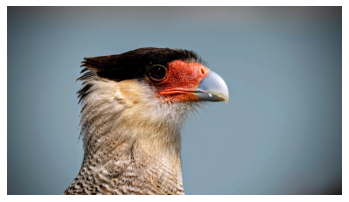

In [ ]:
# Загрузка и отображение
image = load_img('image.jpg') # загружаем в память с диска
image = img_to_array(image).astype('uint8') # конвертируем в тензор целых чисел
data = np.expand_dims(image, 0) # добавляем еще одно измерение, это измерение примеров, здесь он один.
plt.axis('off') # 
plt.imshow(data[0]) # рисуем

Вот с этим изображением мы будем проводить аугментации. 

Чтобы сделать это, надо создать генератор ImageDataGenerator, в котором перечислить все аугментации, и вызвать метод .fit() с исходными данными чтобы посчитались все необходимые величины. Используем метод .flow() для получения аугментированных изображений из исходных, используем next(), чтобы получить следущий пример из генератора.


Для начала сделаем пустой генератор, который не применяет никаких аугментаций. Для рисование результата генерации сделаем вспомогательную функцию.

In [ ]:
# Создаем пустой генератор
def default_datagen():
  # создаем генератор, указываем общие аргументы,
  
  datagen = ImageDataGenerator( fill_mode='constant', # чем заполнять пиксели которые оказались пустыми, по умолчанию 0
                               dtype='uint8')   # тип данных
  datagen.fit(data) # настраиваем под данные все переменные (среднее, разброс и др.) 
  return datagen

In [ ]:
def plot_augmentation(datagen, data, n_rows=1, n_cols=5):
  '''
  Выполняем аугментации и рисуем результат
  принимает генератор ImageDataGenerator, исходные данные (изображения) data.
  можем указать число строк и столбцов для результата n_rows и n_cols (по умолчанию 1, 5)
  '''
  n_images = n_rows * n_cols # число генерируемых аугментированных изображений
  gen_flow = datagen.flow(data) # задаем их генераторе
  # рисуем
  plt.figure(figsize=(n_cols*4, n_rows*3)) 
  for image_index in range(n_images):
    image = next(gen_flow).astype('uint8') # следующее изображение из генератора 
    #print(image.min(), image.max(), image.dtype)
    plt.subplot(n_rows, n_cols, image_index+1) # его подграфик
    plt.axis('off')
    plt.imshow(image[0], vmin=0, vmax=255) # рисуем его

## Аугментации
Берем начальный генератор, добавляем ему поля для нужных аугментаций, выполняем их, смотрим на результат. 
### Сдвиг


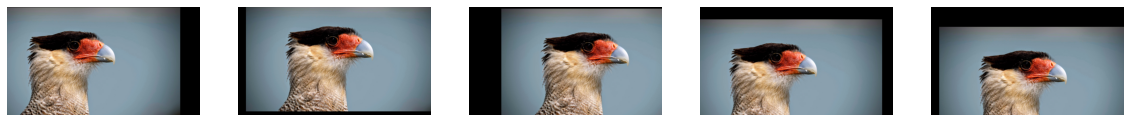

In [ ]:
datagen = default_datagen() # пустой генератор
datagen.width_shift_range = 0.2 # добавляем сдвиги по ширине
datagen.height_shift_range = 0.2 # добавляем сдвиги по высоте
plot_augmentation(datagen, data) # выполняем и рисуем

### Отражения

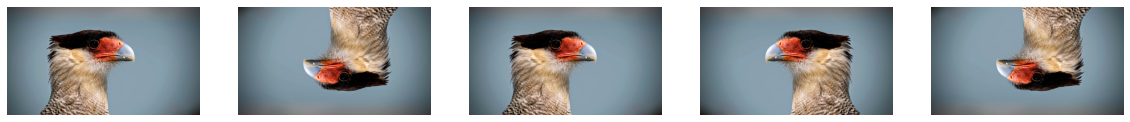

In [ ]:
datagen = default_datagen() # пустой генератор
datagen.horizontal_flip = True # добавляем отражения по горизонтали
datagen.vertical_flip = True # добавляем отражения по вертикали
plot_augmentation(datagen, data) # выполняем и рисуем

### Повороты

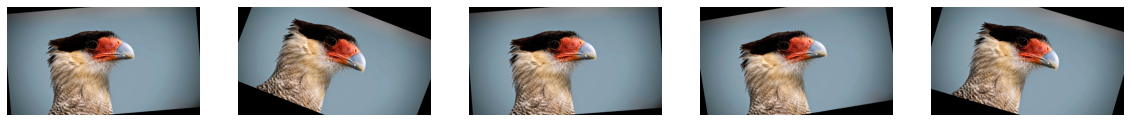

In [ ]:
datagen = default_datagen() # пустой генератор
datagen.rotation_range = 25 # добавляем повороты (в градусах +-)
plot_augmentation(datagen, data) # выполняем и рисуем

### Масштаб

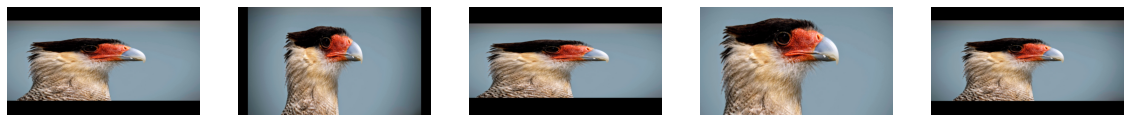

In [ ]:
datagen = default_datagen() # пустой генератор
datagen.zoom_range = [0.5, 1.5] # добавляем масштаб от...до 
plot_augmentation(datagen, data) # выполняем и рисуем

### Параллелограмность

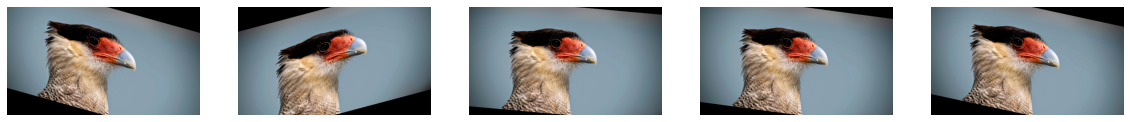

In [ ]:
datagen = default_datagen() # пустой генератор
datagen.shear_range = 20 # добавляем параллелограмность 
plot_augmentation(datagen, data) # выполняем и рисуем

### Яркость

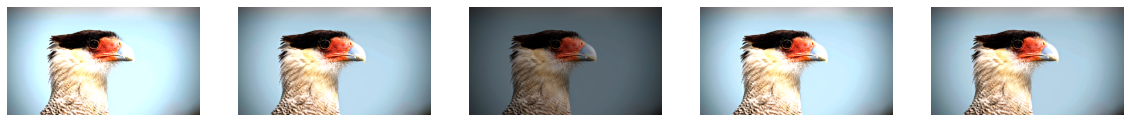

In [ ]:
datagen = default_datagen() # пустой генератор
datagen.brightness_range = [0.5, 2.0] # добавляем яркость
plot_augmentation(datagen, data) # выполняем и рисуем

### Все вместе
Несколько аугментаций могут быть применены одновременно. Попробуйте другие аугментации и параметры.

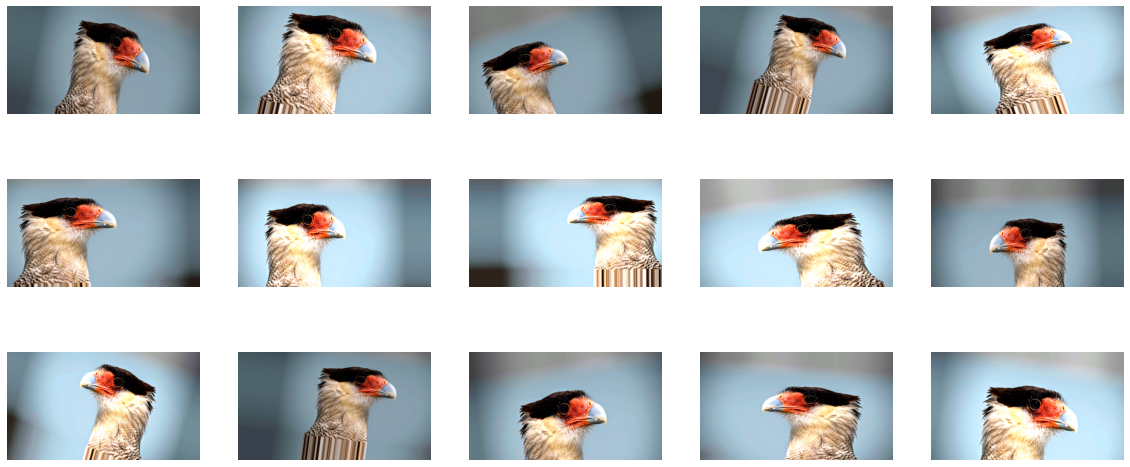

In [ ]:
datagen = default_datagen() # пустой генератор
datagen.fill_mode='nearest' # изменим, чем заполнять пустые пиксели, теперь ближайшими 
datagen.horizontal_flip=True # горизонтальные отражения
datagen.width_shift_range=0.2 # сдвиг по ширине
datagen.height_shift_range=0.2 # сдвиг по высоте
datagen.zoom_range=[0.8, 1.2] # масштаб
datagen.rotation_range=20 # поворот
datagen.brightness_range = [0.75, 1.5] # яркость
plot_augmentation(datagen, data, n_rows=3, n_cols=5) # выполняем и рисуем

Из одной картинки, получили множество измененных, которые вполне могли встретиться в реальности. 

# Классификация кошек и собак с аугментацией данных

Но давайте посмотрим, как аугментация влияет на работу моделей, попробуем различить кошек и собак с и без аугментации.

In [ ]:
import tensorflow as tf # для работы с нейронными сетями
from tensorflow.keras.preprocessing.image import ImageDataGenerator # генератор данных
import os # для работы с файловой системой
import numpy as np #
import matplotlib.pyplot as plt #

## Загрузка данных

Будем работать с набором данных, содержащим изображения [кошек и собак](https://www.kaggle.com/c/dogs-vs-cats/data). Загрузим 
его с URL, распакуем.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


Набор данных имеет следующую структуру на диске:.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Пропишем пути к файлам.

In [ ]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered') # директория с данными
train_dir = os.path.join(base_dir, 'train') # файлы для обучения
validation_dir = os.path.join(base_dir, 'validation') # файлы для проверки

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')  # файлы для обучения с кошками
train_dogs_dir = os.path.join(train_dir, 'dogs')  # файлы для обучения с собаками
validation_cats_dir = os.path.join(validation_dir, 'cats')  # файлы для проверки с кошками
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # файлы для проверки с собаками

### Посмотрим на данные

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir)) # количество файлов для обучения с кошками
num_dogs_tr = len(os.listdir(train_dogs_dir)) # с собаками

num_cats_val = len(os.listdir(validation_cats_dir)) # количество файлов для проверки с кошками
num_dogs_val = len(os.listdir(validation_dogs_dir)) # с собаками

total_train = num_cats_tr + num_dogs_tr # общее число файлов для обучения
total_val = num_cats_val + num_dogs_val # для проверки

In [ ]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


## Параметры модели

In [ ]:
BATCH_SIZE = 100 # число примеров в пакете
IMG_SHAPE  = 150 # размер изображений (150 на 150 пикселей

# Аугментация данных

Вспомогательная функция для рисования

In [ ]:
# функция для рисования
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Создаем генератор для обучающих данных с аугментациями, вы можете выбрать и другие аугментации\параметры.

In [ ]:
image_gen_train = ImageDataGenerator(
      rescale=1./255, # изменение величины пикселей, это по сути приведет к диапозону 0...1
      rotation_range=40, # повороты
      width_shift_range=0.2, # сдвиги
      height_shift_range=0.2, # сдвиги
      shear_range=0.2, # параллелограмность
      zoom_range=0.2, # масштаб
      horizontal_flip=True, # зеркальные отражения
      fill_mode='nearest') # как заполнять пустые пиксели


In [ ]:
## Без аугментаций
#image_gen_train = ImageDataGenerator(
#      rescale=1./255, # изменение величины пикселей, это по сути приведет к диапозону 0...1
#      fill_mode='nearest') # как заполнять пустые пиксели

Сейчас наши данные на диске, а не в памяти компьютера. Чтобы генератор брал их с диска используем метод **flow_from_directory** (вместо flow), указываем размер пакета, директорию с данными, перемешивать ли их, размер результирующего изображения, способ задания меток (указаний учителя). Здесь всего два класса (кошки и собаки), поэтому бинарная классификация.  

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE, # размер пакета
                                                     directory=train_dir, #директория с данными
                                                     shuffle=True, # перемешивать ли
                                                     target_size=(IMG_SHAPE,IMG_SHAPE), # размер результата
                                                     class_mode='binary') # способ задания меток

Found 2000 images belonging to 2 classes.


Посмотрим на некоторые аугментированные изображения.  

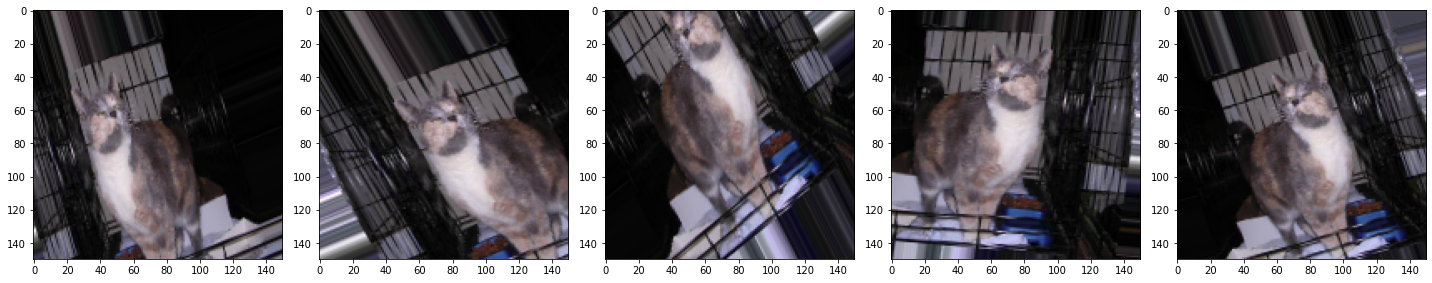

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Генератор проверочных данных
Для проверочных данных возможно, но не точно, нет смысла делать все-все аугментации, достаточно самых распространенных или вообще без них. Ведь все-таки задача проверки узнать, насколько хороша модель на реальных данных. Здесь мы только приведем значения пикселей к 0...1, поделив их на 255. 

In [ ]:
# генератор проверочных данных
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# Создание модели классификации

Это будет обычная сеть с четырьмя сверточными слоями, слоями макспулинга.

Добавим и слой Dropout перед полносвязным с вероятностью отброса 0.5.

Полносвязный слой с 512 нейронами и `relu` активацией. Два выхода (по числу классов) с .функцией активации `softmax`.

Вы можете модифицировать сеть по своему усмотрению.

In [ ]:
model = tf.keras.models.Sequential([ # сеть из последовательных слоев, перечисляем:
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)), # сверточный 
    tf.keras.layers.MaxPooling2D(2, 2), # пулинг

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # сверточный
    tf.keras.layers.MaxPooling2D(2,2), # пулинг

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # сверточный
    tf.keras.layers.MaxPooling2D(2,2), # пулинг

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # сверточный
    tf.keras.layers.MaxPooling2D(2,2), # пулинг

    tf.keras.layers.Dropout(0.5), # регуляризация дропаут
    tf.keras.layers.Flatten(), # вытягиваем все в вектор
    tf.keras.layers.Dense(512, activation='relu'), # полносвязный
    tf.keras.layers.Dense(2) # выходной
])

### Параметры модели

Используем метод обучения  `adam`. Функция ошибки `sparse_categorical_crossentropy`. 
Наблюдаем за аккуратностью accuracy классификации (метрика).

In [ ]:
model.compile(optimizer='adam', # метод обучения
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # функция ошибки
              metrics=['accuracy']) # метрика

In [ ]:
model.summary() # информация о модели

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Обучение модели

Наши данные теперь создаются генератором, в старых версиях tensorflow нужно использовать метод  `fit_generator` вместо привычного `fit`, в этой не надо.

In [ ]:
epochs=100 # количество эпох
# обучаем (~15 минут)
history = model.fit(
    train_data_gen, # генератор обучающих данных
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))), # количество примеров на одну эпоху
    epochs=epochs, # количество эпох
    validation_data=val_data_gen, # генератор проверочных данных
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))) # как часто проводить проверку
)

Epoch 1/100
20/20 [==============================] - 51s 1s/step - loss: 0.8014 - accuracy: 0.5198 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 20s 1s/step - loss: 0.6898 - accuracy: 0.5149 - val_loss: 0.6913 - val_accuracy: 0.5970
Epoch 3/100
20/20 [==============================] - 20s 1s/step - loss: 0.6909 - accuracy: 0.5173 - val_loss: 0.6695 - val_accuracy: 0.5340
Epoch 4/100
20/20 [==============================] - 20s 1s/step - loss: 0.6748 - accuracy: 0.5690 - val_loss: 0.6353 - val_accuracy: 0.6420
Epoch 5/100
20/20 [==============================] - 20s 1s/step - loss: 0.6929 - accuracy: 0.5574 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 6/100
20/20 [==============================] - 20s 1s/step - loss: 0.6876 - accuracy: 0.5156 - val_loss: 0.6913 - val_accuracy: 0.5070
Epoch 7/100
20/20 [==============================] - 20s 1s/step - loss: 0.6873 - accuracy: 0.5335 - val_loss: 0.6822 - val_accuracy: 0.5460
Epoch 8/100
2

### Визуализация результатов

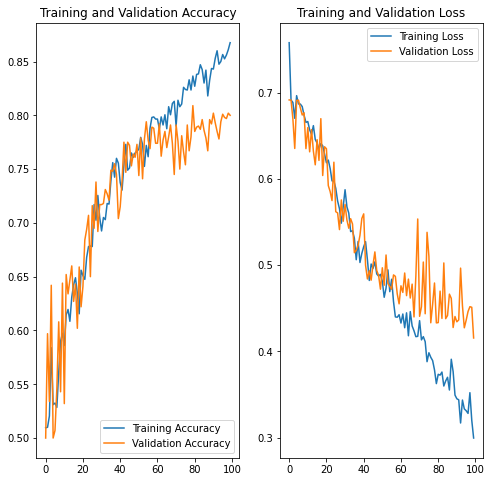

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Получилось довольно не плохо (но, конечно, не идеально) 80% аккуратности на проверке, 86% на обучении. 

Сделате то же самое, но уберите все аугментации (кроме не случайных) и сравните.

У меня получилось 78% аккуратности на проверке (еще и возрастает), 99% на обучении! Явно проблема переобучения.  Но зато обучение было в два раза быстрее.

Итак, аугментация приносит пользу в борьбе с переобучением.

# Создание своего генератора данных.
Это дополнительная, необязательная тема.

Поддерживается возможность создавать свои генераторы, для тех аугментаций, которые еще не встроили. Для этого надо создать новый  класс, который наследовал бы класс ImageDataGenerator, и добавить в него нужные функции\параметры обработки.

Для примера сделаем аугментацию цветовых каналов, когда будем умножать все значения в канале на случайное число из заданного диапазона, для каждого канала свой.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import requests
import random

Загрузим изображение

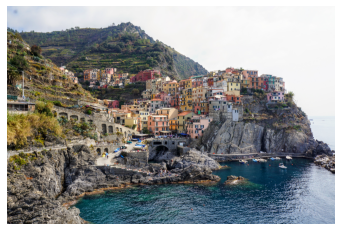

In [ ]:
url = 'https://github.com/dufourpascal/stepupai/raw/master/tutorials/data_augmentation/image_town.jpg'
r = requests.get(url, allow_redirects=True)
open('image.jpg', 'wb').write(r.content)

image = load_img('image.jpg')
image = img_to_array(image).astype(int)
data = np.expand_dims(image, 0)
plt.axis('off')
plt.imshow(data[0])

Создадим новый класс генератора.

In [ ]:
class CustomDataGenerator(ImageDataGenerator): # делаем новый класс, наследник от ImageDataGenerator 
  # инициализация класса, передаем новые аргументы и все старые в **kwargs
  def __init__(self,
               red_range=None, # диапазон для канала красного цвета
               green_range=None, # диапазон для канала зеленого цвета
               blue_range=None, # диапазон для синего красного цвета
               **kwargs):
    '''
    Собственный генератор данных, поддерживает все функции ImageDataGenerator но дает еще и аугментацию цветов
    '''
    # задаем новые функции и параметры
    super().__init__(
        preprocessing_function=self.augment_color,
        **kwargs)

    self.red_range = red_range
    self.green_range = green_range
    self.blue_range = blue_range
  # функция аугментации цветов
  def augment_color(self, image):
    '''принимает изображение и возвращает модифицированное'''
    channel_ranges = (self.red_range, self.green_range, self.blue_range) # диапазоны изменения цветов
    for channel, channel_range in enumerate(channel_ranges): # цвета это каналы, перебираем каналы изображения
      if not channel_range: 
        continue  # если для какого-то цвета диапазоны не заданы, то и обрабатывать его не надо, пропускаем  
      scale = random.uniform(channel_range[0], channel_range[1]) # случайно задаем множитель из диапазона 
      image[:, :, channel] = image[:, :, channel] * scale # изменяем канал\цвет

    image = np.clip(image, 0, 255) # обрезаем если значения выходят за диапазон значений пикселей
    return image # возвращаем изображение

Проверим, как работает. Разумеется, новый генератор, поддерживает и функции старого ImageDataGenerator, от которого он наследовал. 

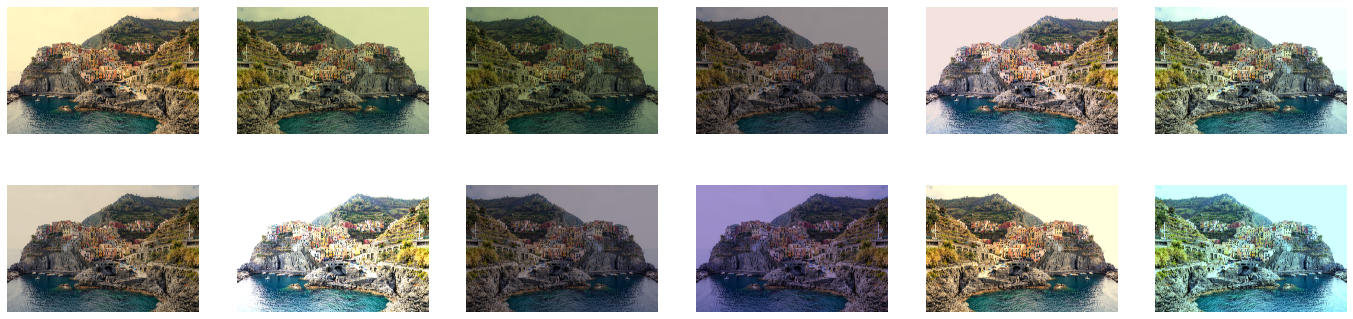

In [ ]:
datagen = CustomDataGenerator(red_range=(0.8, 1.2),
                              green_range=(0.8, 1.2),
                              blue_range=(0.8, 1.2),
                              brightness_range=(0.5, 1.5), # это аргумент из "старого" генератора
                              horizontal_flip = True, # это аргумент из "старого" генератора
                              dtype=int)
datagen.fit(data)
plot_augmentation(datagen, data, n_rows=2, n_cols=6)

# Заключение
Отметим, что здесь показаны только простейшие аугментации изображений. Для каждой задачи можно придумать новые, лучшие, аугментации, бывают, например, такие:
- вырезаем часть изображения. Это имитация потери части объекта, например кошечка спрятала голову за диваном, 
- накладываем часть изображения на другое.  Это имитация перекрытия объектов, например котик подошел вплотную к собачке.
- повороты в трехмерном пространстве, важно для камер автопилотов.
- изменение цветов, имитация проблем видео
- "рыбий глаз", имитация проблем видеокамер.
- и прочие, прочие, прочие.   

Другие типы данных требуют других аугментаций. Также надо обращать внимание и на время выполнения аугментаций.

# Ссылки

Использованы и адаптированы материалы

https://colab.research.google.com/github/dufourpascal/stepupai/blob/master/tutorials/data_augmentation/exploring_data_augmentation_keras.ipynb#scrollTo=2KpA-QvpPCqi

https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c02_dogs_vs_cats_with_augmentation.ipynb#scrollTo=tGNKLa_YVrXR

https://colab.research.google.com/github/dufourpascal/stepupai/blob/master/tutorials/data_augmentation/custom_data_augmentation_keras.ipynb


